In [236]:
import os
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [237]:
con = duckdb.connect()

project_root = Path.cwd().parent
games_path = project_root/"out"/"parquet_joined"

In [238]:
query = f"""
CREATE OR REPlACE VIEW games_clean AS
SELECT * FROM parquet_scan('{games_path}/*.parquet')
"""

con.execute(query)

In [239]:
query = f"""
SELECT COUNT(*) FROM games_clean
"""
con.execute(query).fetchall()

[(9971559,)]

In [240]:
binsize = 50
query = f"""
SELECT
    CAST(((white_elo + black_elo)/2 / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
    COUNT(*) AS total_games,
    SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) AS draws
FROM games_clean
GROUP BY elo_bin
ORDER BY elo_bin

"""
df = con.execute(query).fetchdf()

In [241]:
rolling_bins = 10
min_games_per_bin = 200

df['draw_rate'] = df['draws'] / df['total_games']
# Smooth with rolling average
df['draw_rate_smooth'] = (
    (df['draw_rate'] * df['total_games'])
    .rolling(window=rolling_bins, center=True, min_periods=1)
    .sum() /
    df['total_games'].rolling(window=rolling_bins, center=True, min_periods=1).sum()
)

df_plot = df[df['total_games'] >= min_games_per_bin]

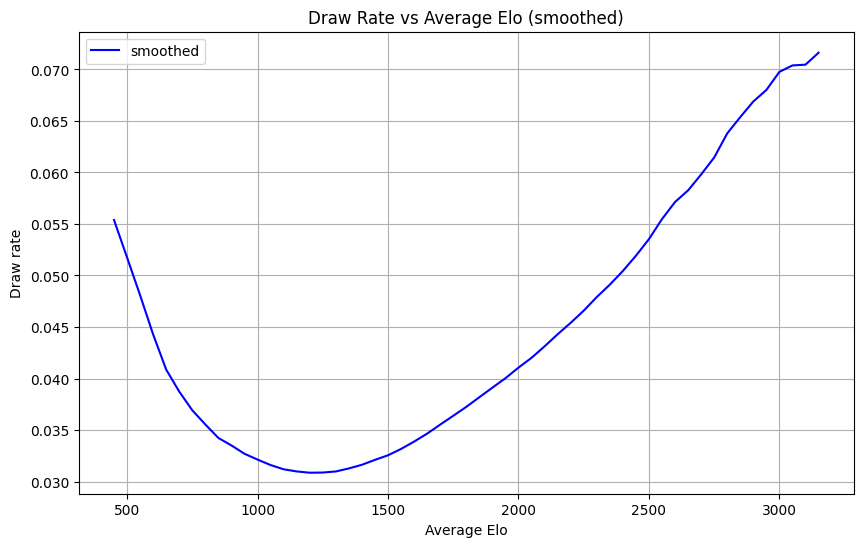

In [242]:
plt.figure(figsize=(10,6))
plt.plot(df_plot['elo_bin'], df_plot['draw_rate_smooth'], color='blue', label='smoothed')
plt.xlabel('Average Elo')
plt.ylabel('Draw rate')
plt.title('Draw Rate vs Average Elo (smoothed)')
plt.grid(True)
plt.legend()
plt.show()


Interesting behaviour.... draws increase at higher level as expected due to more accurate play, however draws also seem to increase at lower level. lets split into draws by time control

In [243]:
time_controls = ("Classical", "Rapid","Blitz","Bullet","UltraBullet","Correspondence","Other")
tc_list_sql = ",".join([f"'{t}'" for t in time_controls])

In [244]:
def plot_separate_tc(y):
    
    df[y] = df[f'{y[:4]}s'] / df['total_games']

    def weighted_smooth_group(g, window=rolling_bins):
        g = g.sort_values('elo_bin').reset_index(drop=True)
        # columns needed
        rate = g[y]
        n = g['total_games']
        # weighted rolling: numerator = sum(rate * n), denom = sum(n)
        num = (rate * n).rolling(window=window, center=True, min_periods=1).sum()
        denom = n.rolling(window=window, center=True, min_periods=1).sum()
        g[f'{y}_smooth'] = num / denom
        return g

    df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))
    
    plt.figure(figsize=(12,7))

    min_games_per_bin = 10

    colors = {
        "Classical":"#9467bd",
        "Rapid":"#d62728",
        "Blitz":"#2ca02c",
        "Bullet":"#ff7f0e",
        "UltraBullet":"#1f77b4",
    }

    legend_handles = []
    legend_labels = []

    for tc in time_controls:
        if tc != "Correspondence":
            g = df_smoothed[df_smoothed['time_control'] == tc].sort_values('elo_bin')
            if g.empty:
                continue

            # mask (exclude) bins with too few games
            g_plot = g[g['total_games'] >= min_games_per_bin]

            if g_plot.empty:
                # nothing to plot for this TC (all bins too small) -> skip plotting entirely
                continue

            # plot the (masked) smoothed line
            h, = plt.plot(
                g_plot['elo_bin'],
                g_plot[f'{y}_smooth'],
                label=tc,
                linewidth=2,
                color=colors.get(tc, 'k'),
                zorder=2
            )


            
            # record handle/label in order so legend respects this order
            legend_handles.append(h)
            legend_labels.append(tc)

    # now create legend using the collected handles in that order
    plt.legend(legend_handles, legend_labels, title='Time control', loc='best')

    plt.xlabel('Average Elo')
    plt.ylabel(f'{y}')
    plt.title(f'{y} vs Average Elo by time control (binsize={binsize}, window={rolling_bins})')
    plt.grid(True)
    plt.show()

In [245]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END AS is_draw,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(is_draw) AS draws,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_11112\3210387426.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


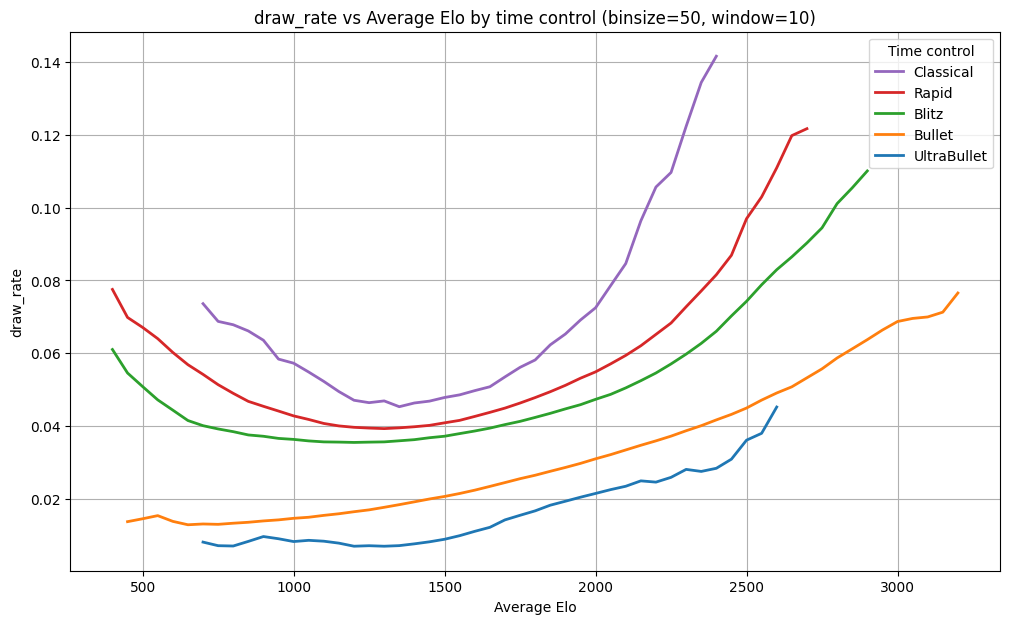

In [246]:
plot_separate_tc('draw_rate')

okay we see in the faster gamemodes (Bullet and UltraBullet) we still see an increase at the higher levels but not at the lower levels. lets try to see how different games ended to see if that gives us an indication

In [247]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN mated IS TRUE THEN 1 ELSE 0 END AS was_mated,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(was_mated) AS mates,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_11112\3210387426.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


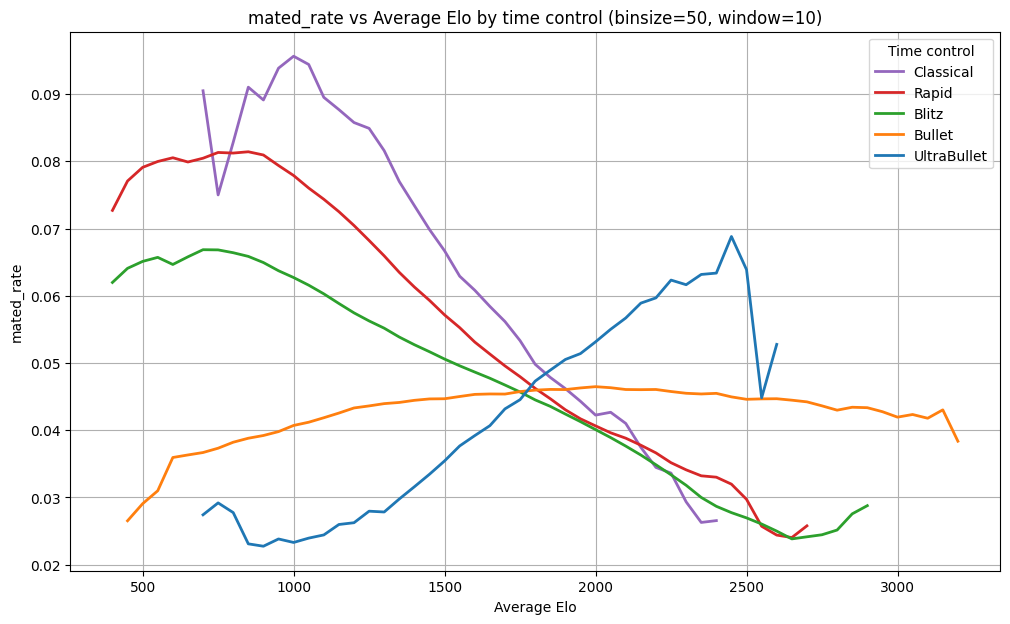

In [248]:
plot_separate_tc('mated_rate')

As somewhat expected for gamemodes where time is not so much of an issue, 

In [249]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN termination = 'Time forfeit' THEN 1 ELSE 0 END AS flag,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(flag) AS flags,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_11112\3210387426.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


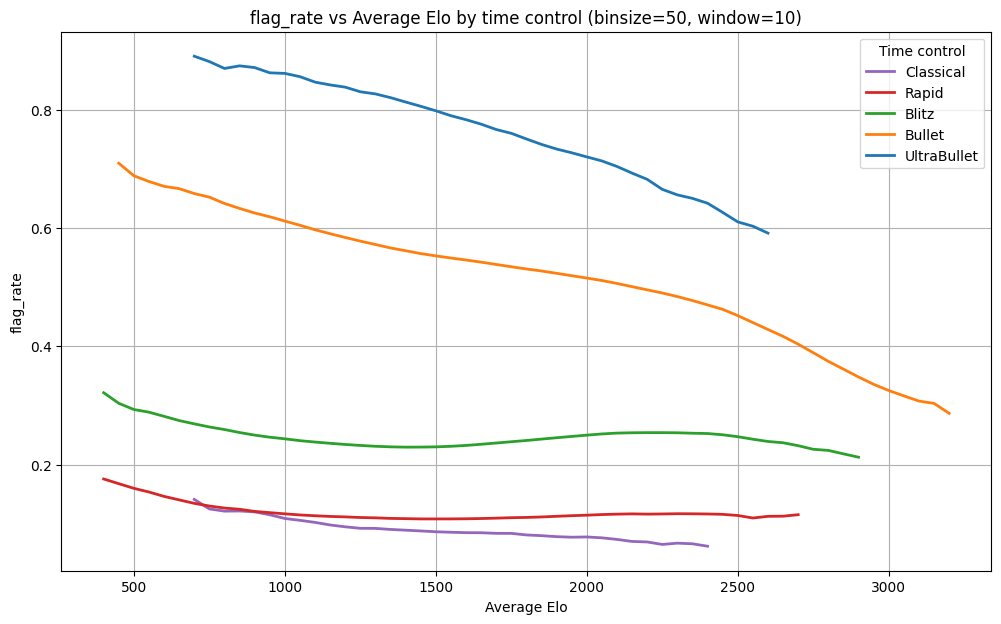

In [250]:
plot_separate_tc('flag_rate')

In [251]:
con.close()